## Mathematics and Methods in Machine Learning and Neural Networks - Logistic regression
Metropolia University of Applied Sciences  
Daniel Ridzon  
15/02/2022

### Libraries import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from joblib import dump
from scipy.io import arff
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

### Load the data

In [2]:
data = arff.loadarff("data/column_3C_weka.arff")
df = pd.DataFrame(data[0])

### Basic metrics of the dataset.

In [3]:
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,b'Hernia'
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,b'Hernia'
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,b'Hernia'
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,b'Hernia'
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,b'Hernia'
...,...,...,...,...,...,...,...
305,47.903565,13.616688,36.000000,34.286877,117.449062,-4.245395,b'Normal'
306,53.936748,20.721496,29.220534,33.215251,114.365845,-0.421010,b'Normal'
307,61.446597,22.694968,46.170347,38.751628,125.670725,-2.707880,b'Normal'
308,45.252792,8.693157,41.583126,36.559635,118.545842,0.214750,b'Normal'


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
pelvic_incidence,310.0,60.496653,17.236520,26.147921,46.430294,58.691038,72.877696,129.834041
pelvic_tilt,310.0,17.542822,10.008330,-6.554948,10.667069,16.357689,22.120395,49.431864
lumbar_lordosis_angle,310.0,51.930930,18.554064,14.000000,37.000000,49.562398,63.000000,125.742385
sacral_slope,310.0,42.953831,13.423102,13.366931,33.347122,42.404912,52.695888,121.429566
pelvic_radius,310.0,117.920655,13.317377,70.082575,110.709196,118.268178,125.467674,163.071041
degree_spondylolisthesis,310.0,26.296694,37.559027,-11.058179,1.603727,11.767934,41.287352,418.543082


In [5]:
df["class"].unique()

array([b'Hernia', b'Spondylolisthesis', b'Normal'], dtype=object)

#### Check feture types

In [6]:
df.dtypes

pelvic_incidence            float64
pelvic_tilt                 float64
lumbar_lordosis_angle       float64
sacral_slope                float64
pelvic_radius               float64
degree_spondylolisthesis    float64
class                        object
dtype: object

#### Class distribution

Class distribution: Normal 32.26%, Spondylolisthesis 48.39%, Hernia 19.35%


<AxesSubplot:>

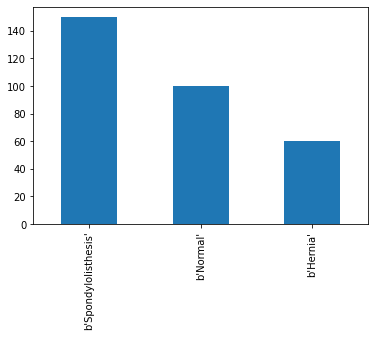

In [7]:
# Count occurances of each class
normal_cnt = df["class"].value_counts()[b"Normal"]
spondylolisthesis_cnt = df["class"].value_counts()[b"Spondylolisthesis"]
hernia_cnt = df["class"].value_counts()[b"Hernia"]
total_cnt = normal_cnt + spondylolisthesis_cnt + hernia_cnt

# Measure percentage of each class for later balancing.
normal_p = normal_cnt / total_cnt
spondylolisthesis_p = spondylolisthesis_cnt / total_cnt
hernia_p = hernia_cnt / total_cnt

print(f"Class distribution: Normal {(normal_p * 100):.2f}%, Spondylolisthesis {(spondylolisthesis_p * 100):.2f}%, Hernia {(hernia_p * 100):.2f}%")

# Plot the clas distribution
df["class"].value_counts().plot(kind="bar")

##### Observations
- Classes are not equal with distribution - We will need to account for that in fitting phase.

#### Feature correlation

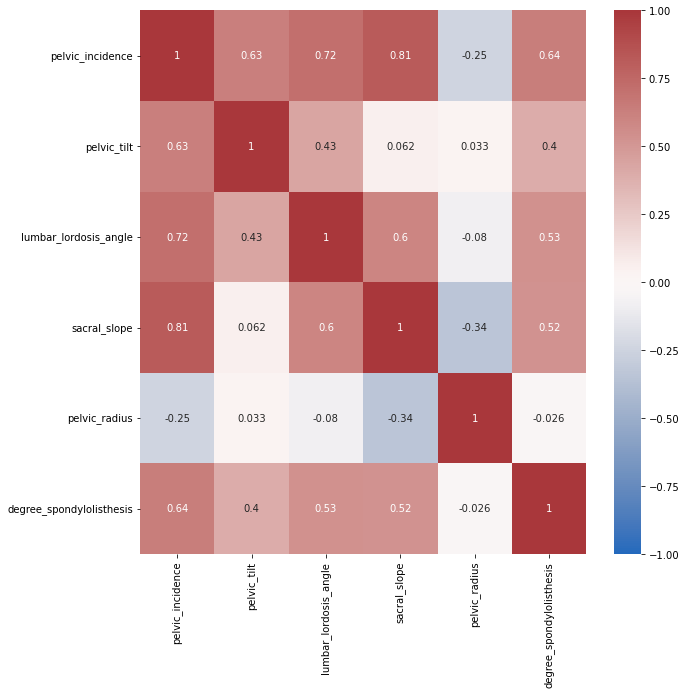

In [8]:
# Plotting the correlation heatmap
plt.figure(figsize=(10,10))
dataplot = sns.heatmap(df.corr(), cmap="vlag", annot=True, vmin=-1, vmax=1)
  
# Displaying the heatmap
plt.show()

##### Observations
- Highest correlation of 81% is between sacral_slope and pelvic_incidence. But it is still not too high for dropping one of the features. (One of the features with correlation between (+-) 0.9 and 1.0 should be eliminated from the dataset to prevent later problems in training).

#### Mean of features for specific classes

In [9]:
df.groupby("class").mean()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
class,,,,,,
b'Hernia',47.638407,17.398795,35.463524,30.239612,116.474968,2.480251
b'Normal',51.685244,12.821414,43.542605,38.863830,123.890834,2.186572
b'Spondylolisthesis',71.514224,20.748038,64.110108,50.766186,114.518810,51.896687


##### Observations
- Class Spondylolisthesis has much higher mean value of degree_spondylolisthesis feature

### Preprocessing

#### Shuffling rows
We need to shuffle the rows before fitting the model, because dataset is ordered by the target classes.

In [10]:
# Sampling by size of 1, will return the whole dataset but with rows in random order.
df = df.sample(frac=1, random_state=100)
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
75,70.221452,39.822724,68.118403,30.398728,148.525562,145.378143,b'Spondylolisthesis'
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,b'Hernia'
250,36.157830,-0.810514,33.627314,36.968344,135.936910,-2.092507,b'Normal'
56,43.349606,7.467469,28.065483,35.882137,112.776187,5.753277,b'Hernia'
149,79.249671,23.944825,40.796698,55.304846,98.622512,36.706395,b'Spondylolisthesis'
...,...,...,...,...,...,...,...
66,78.491730,22.181798,60.000000,56.309932,118.530327,27.383213,b'Spondylolisthesis'
53,30.149936,11.917445,34.000000,18.232491,112.684141,11.463223,b'Hernia'
79,47.744679,12.089351,39.000000,35.655328,117.512004,21.682401,b'Spondylolisthesis'
280,50.086153,13.430044,34.457541,36.656108,119.134622,3.089484,b'Normal'


#### Check for missing values

In [11]:
df.isna().sum()

pelvic_incidence            0
pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

Dataset doesn't have any missing values, so we don't need to fix them.

#### Rename class cases to numeric values
Normal -> 0  
Hernia -> 1  
Spondylolisthesis -> 2


In [12]:
df["class"] = df["class"].astype("string")

class_names = ["Normal", "Hernia", "Spondylolisthesis"]
df["class"] = df["class"].replace("b'Normal'", "0")
df["class"] = df["class"].replace("b'Hernia'", "1")
df["class"] = df["class"].replace("b'Spondylolisthesis'", "2")

df["class"] = df["class"].astype("int")
df

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
75,70.221452,39.822724,68.118403,30.398728,148.525562,145.378143,2
7,45.366754,10.755611,29.038349,34.611142,117.270067,-10.675871,1
250,36.157830,-0.810514,33.627314,36.968344,135.936910,-2.092507,0
56,43.349606,7.467469,28.065483,35.882137,112.776187,5.753277,1
149,79.249671,23.944825,40.796698,55.304846,98.622512,36.706395,2
...,...,...,...,...,...,...,...
66,78.491730,22.181798,60.000000,56.309932,118.530327,27.383213,2
53,30.149936,11.917445,34.000000,18.232491,112.684141,11.463223,1
79,47.744679,12.089351,39.000000,35.655328,117.512004,21.682401,2
280,50.086153,13.430044,34.457541,36.656108,119.134622,3.089484,0


#### Split dataset into train, validation and test subsets

In [13]:
# Split the data into train (60%), validation (20%) and test datasets (20%)
train_df, validation_df, test_df = np.split(df.sample(frac=1, random_state=42), [int(.6*len(df)), int(.8*len(df))])

print(f"train: {len(train_df.index)}, validation: {len(validation_df.index)}, test: {len(test_df.index)}")

train: 186, validation: 62, test: 62


#### Separate features and labels

In [14]:
# Separate features (X) and labels (Y)
train_X = train_df.copy()
validation_X = validation_df.copy()
test_X = test_df.copy()

train_Y = train_X.pop("class")
validation_Y = validation_X.pop("class")
test_Y = test_X.pop("class")

FEATURES = len(train_X.columns)
print("Number of features:", FEATURES)

Number of features: 6


#### Prepare class weights for training

In [15]:
class_weights = {
    0: 1 - normal_p,
    1: 1 - hernia_p,
    2: 1 - spondylolisthesis_p
}
class_weights

{0: 0.6774193548387097, 1: 0.8064516129032258, 2: 0.5161290322580645}

### Training the model

In [16]:
# Try different penalties to check, which will produce the best results.
penalties = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]
models = {}

for p in penalties:

    # Dedine the model
    if p == 0.0:
        model = LogisticRegression(multi_class="multinomial", class_weight=class_weights, max_iter=2000, penalty="none")
    else:
        model = LogisticRegression(multi_class="multinomial", class_weight=class_weights, max_iter=2000, penalty="l2", C=p)

    # Fit the model with the train data
    model.fit(train_X, train_Y)

    # Test model with validation data
    predict_Y = model.predict(validation_X)
    accuracy = metrics.accuracy_score(validation_Y, predict_Y)
    models[p] = {
        "model": model,
        "accuracy": accuracy,
        "penalty": p
    }

In [17]:
for key, model in models.items():
    print(f'penalty: {model["penalty"]}, accuracy: {model["accuracy"]:.5f}')

penalty: 0.0, accuracy: 0.82258
penalty: 0.0001, accuracy: 0.77419
penalty: 0.001, accuracy: 0.87097
penalty: 0.01, accuracy: 0.83871
penalty: 0.1, accuracy: 0.82258
penalty: 1.0, accuracy: 0.82258


#### Observations
I got best accuracy with 0.001 penalty, so I choosed themodel for the final evaluation.

### Final evaluation

In [18]:
# Get the model
model = models[0.001]

# Save the model to persistent storage
dump(model["model"], "model.model")

['model.model']

#### Test model on test dataset

In [19]:
# Test model with test data
predict_Y = model["model"].predict(test_X)
accuracy = metrics.accuracy_score(test_Y, predict_Y)
accuracy

0.8709677419354839

#### Confusion matrix

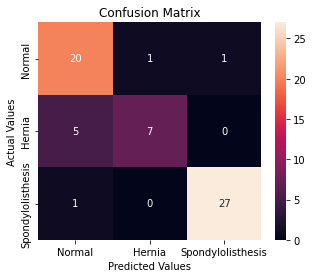

In [20]:
# Creating a confusion matrix - source: https://www.analyticsvidhya.com/blog/2021/06/confusion-matrix-for-multi-class-classification/
cm = confusion_matrix(test_Y, predict_Y)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(
    cm,
    index = class_names, 
    columns = class_names
)

# Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predicted Values")
plt.show()

#### Precision & Recall

In [21]:
for i in range(0, 3):
    actual_cnt = cm[i, 0] + cm[i, 1] + cm[i, 2]
    predicted_cnt = cm[0, i] + cm[1, i] + cm[2, i]

    recall = cm[i, i] / actual_cnt
    precision = cm[i, i] / predicted_cnt

    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}       - {class_names[i]}")

Precision: 0.77, Recall: 0.91       - Normal
Precision: 0.88, Recall: 0.58       - Hernia
Precision: 0.96, Recall: 0.96       - Spondylolisthesis


### Conclusion

We have achieved overall accuracy of 87% on the test dataset.

For Hernia            class recall (sensitivity) is 58% and precision is 88%.  
For Spondylolisthesis class recall (sensitivity) is 96% and precision is 96%.

## Diagnostic tool for experts
(Function imports libraries again and loads the classifier from the file, as it would be used in real enviroment without context of this notebook)

In [22]:
import pandas as pd

from joblib import load


def predict_diagnose(pelvic_incidence, pelvic_tilt, lumbar_lordosis_angle, sacral_slope, pelvic_radius, degree_spondylolisthesis):

    class_names = ["Normal", "Hernia", "Spondylolisthesis"]
    column_names = ["pelvic_incidence", "pelvic_tilt", "lumbar_lordosis_angle", "sacral_slope", "pelvic_radius", "degree_spondylolisthesis"]

    # Create dataframe from inputed variables
    df_predict = pd.DataFrame(
        [[pelvic_incidence, pelvic_tilt, lumbar_lordosis_angle, sacral_slope, pelvic_radius, degree_spondylolisthesis]],
        index = [0], 
        columns = column_names
    )

    # Load the model.
    model = load("model.model")

    # Predict and print the diagnose.
    print(f"Diagnose prediction is: {class_names[model.predict(df_predict)[0]]}")

### Examples on test samples

In [23]:
# Get some 
t = test_df.sample(n = 3, random_state=3)
t

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
187,60.419932,5.265665,59.814236,55.154267,109.033074,30.265785,2
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
179,68.721910,49.431864,68.056012,19.290046,125.018517,54.691289,2


In [24]:
predict_diagnose(60.419932, 5.265665422, 59.8142356, 55.15426658, 109.0330745, 30.26578534)

Diagnose prediction is: Spondylolisthesis


In [25]:
predict_diagnose( 63.0278175, 22.55258597, 39.60911701, 40.47523153, 98.67291675, -0.254399986)

Diagnose prediction is: Hernia


In [26]:
predict_diagnose( 68.72190982, 49.4318636, 68.0560124, 19.29004622, 125.0185168, 54.69128928)

Diagnose prediction is: Spondylolisthesis


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6e48769b-4983-40ba-98af-41053aae8714' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>